<a href="https://colab.research.google.com/github/ioanabuze/DE_Group_Project_2020/blob/master/Amazon_Review_Weak_Labelling_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code here to push the Notebook to Git

In [ ]:
# Hello World!

In [0]:
# Import Libraries, OS and Setup 

%matplotlib inline

from sklearn import datasets
import numpy as np
import pandas as pd

!pip install snorkel

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis


from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [0]:
# pyspark setup

!pip install pyspark
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive")

     |████████████████████████████████| 217.8MB 64kB/s 
     |████████████████████████████████| 204kB 53.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=e6a12a3b3f13ff117d4fc0aad0ede846b983a9cc634f3192ffca855a02ed5bf3
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cd "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"

In [0]:
import os 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

COLAB_NOTEBOOKS_DATA_PATH="/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"
SPARK_ARCHIVE='spark-2.4.5-bin-hadoop2.7.tgz'
if SPARK_ARCHIVE not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

SPARK_ARTIFACTS='spark-2.4.5-bin-hadoop2.7'
if SPARK_ARTIFACTS not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/spark-2.4.5-bin-hadoop2.7"

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import findspark
findspark.init()

import pyspark
from pyspark.sql import SQLContext

In [0]:
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

PermissionError: ignored

In [0]:
# Import the Data

amazon_reviews_dataset_sql_context = sqlContext.read.csv("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",header=True)
amazon_reviews_dataset_pd_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
youtube_videos_data_rdd = amazon_reviews_dataset_sql_context.rdd

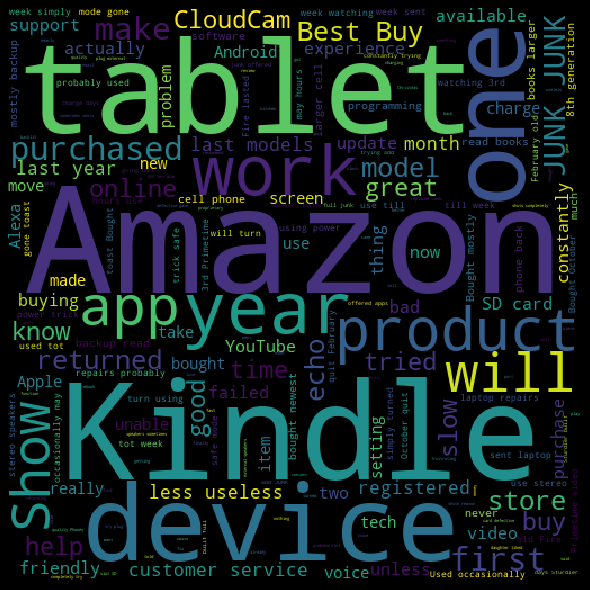

In [0]:
# Visualise the 5 different reviews WordCloud and figure other ways to quantify frequency of words
# From - https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

# WorldCloud - Review == 1 
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==1]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [0]:
ingrdt = amazon_reviews_dataset_pd_df["reviews.text"].str.split(expand=True).stack().value_counts()
ingrdt.head(50)
ingrdt["x"].map(lambda x: x.lower())

excludedwords = ['the', 'to', 'and','I', 'for','a','it','is','my','this','of','with','on','have','in', 'that', 'was', ]
# words = "".join(ingrdt)

# counts = {}
# for word in words:
#     counts[word] = counts.get(word,0) + 1
   
# items = list(counts.items())
# # items [('the', 1137), ('tragedy', 1)]

# # key：取哪行， 默认从小到大，reverse = True 从大到小
# items.sort(key = lambda x:x[1], reverse = True)
# for i in range(1000):
#     word, count = items[i]
#     print("{0:<10}{1:>5}".format(word, count))

the       5757
to        4971
and       4926
I         4333
for       3562
a         3404
it        3049
is        2985
my        2410
this      1843
of        1584
with      1494
on        1200
have      1073
in        1047
that      1040
was        977
The        951
but        897
as         893
you        890
tablet     882
great      878
can        801
so         788
love       777
use        776
not        711
This       699
it.        677
It         654
one        609
very       595
are        594
easy       589
has        569
bought     562
Amazon     502
all        502
like       500
an         497
be         488
loves      484
Great      484
up         479
good       447
My         441
or         419
just       406
would      404
dtype: int64

In [0]:
# Set voting values.
ABSTAIN = -1
SPAM = 1 
HAM = 0

In [0]:
# Labelling Funtions for the 5 different review tiers

@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

    @labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

    @labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN
    
    @labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

In [0]:
# Code to apply all our fucntions
lfs = [#all our functions]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

In [0]:
# Performance Evaluation

In [0]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")